<a href="https://colab.research.google.com/github/nhlong1512/IS252.N21/blob/main/Final/LSTM_02062023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('SP500.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
35/35 [==============================] - 16s 256ms/step - loss: 0.0153 - val_loss: 0.0276
Epoch 2/100
35/35 [==============================] - 8s 241ms/step - loss: 0.0010 - val_loss: 5.7780e-04
Epoch 3/100
35/35 [==============================] - 8s 220ms/step - loss: 4.0898e-04 - val_loss: 8.9725e-04
Epoch 4/100
35/35 [==============================] - 7s 210ms/step - loss: 4.0871e-04 - val_loss: 8.2243e-04
Epoch 5/100
35/35 [==============================] - 8s 236ms/step - loss: 4.0141e-04 - val_loss: 5.5163e-04
Epoch 6/100
35/35 [==============================] - 7s 198ms/step - loss: 3.7192e-04 - val_loss: 8.0729e-04
Epoch 7/100
35/35 [==============================] - 8s 235ms/step - loss: 3.6259e-04 - val_loss: 6.9095e-04
Epoch 8/100
35/35 [==============================] - 8s 219ms/step - loss: 3.6397e-04 - val_loss: 7.0009e-04
Epoch 9/100
35/35 [==============================] - 9s 246ms/step - loss: 3.3111e-04 - val_loss: 6.5077e-04
Epoch 10/100
35/35 [==========

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 37ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 2377.9967650033295
Testing RMSE: 2022.4172139030368


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=267
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.78416347 0.77984466 0.77982344 0.78016462 0.79261976 0.80011616
 0.79345675 0.78354503 0.79091881 0.79701849 0.78622681 0.79536558
 0.79159596 0.78588563 0.7908122  0.79136673 0.78761846 0.79290756
 0.77854907 0.77985533 0.77632041 0.77654964 0.77309465 0.78007936
 0.78257994 0.78100709 0.78091102 0.78633355 0.78197738 0.77998863
 0.77658167 0.77304662 0.77290799 0.76521424 0.757867   0.75291908
 0.75106363 0.77577122 0.78005801 0.79269434 0.79494435 0.7933288
 0.7931955  0.80182765 0.79998821 0.80541607 0.80263276 0.81131294
 0.81385088 0.81479996 0.81940137 0.81320042 0.81476793 0.81164891
 0.80752744 0.80799124 0.81479462 0.81880414 0.8343304  0.83691091
 0.84402357 0.84265326 0.850523   0.8406912  0.84535652 0.84324515
 0.84562311 0.85001117 0.84703598 0.84478598 0.84629492 0.84900872
 0.83889966 0.8385478  0.83298678 0.84311719 0.85000583 0.84907277
 0.85332753 0.8490194  0.8490194  0.8524425  0.84984051 0.85207984
 0.84848088 0.8506136  0.84624155 0.85030444 0.8470

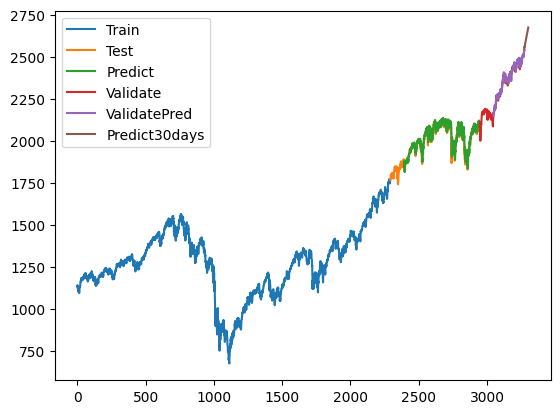

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()